In [3]:
"Using the same IPR (Fetkovich) but different WHP"

# Import Library

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [4]:
# Input Data

q_list = [100, 250, 400, 550, 700, 850]
pwf_list = [1300, 1200, 1100, 1000, 850, 700]       # psia
p_res = 1400                                        # psia
gradient = 0.12                                     # psi/ft
depth = 8000                                        # ft

In [5]:
# Define Function (Log-log Regression)

df = pd.DataFrame({
    'q_stb': q_list,
    'pwf_psig': pwf_list
})
df['delta^2'] = p_res**2 - df['pwf_psig']**2
df['log_q'] = np.log10(df['q_stb'])
df['log_delta2'] = np.log10(df['delta^2'])

fit = np.polyfit(df['log_q'], df['log_delta2'], 1)

n = 1 / fit[0]
c = q_list[0] / (p_res**2 - pwf_list[0]**2)**n

In [7]:
# Define IPR & VLP

pwf_range = np.arange(100, p_res, 10)
q_ipr = [c * (p_res**2 - pwf**2)**n for pwf in pwf_range]

def vlp_model(q, whp):
    return whp + gradient * depth + 0.002 * q**1.5

# Manipulate WHP values

whp_list = [400, 500, 600]
colors = ['blue', 'orange', 'purple']

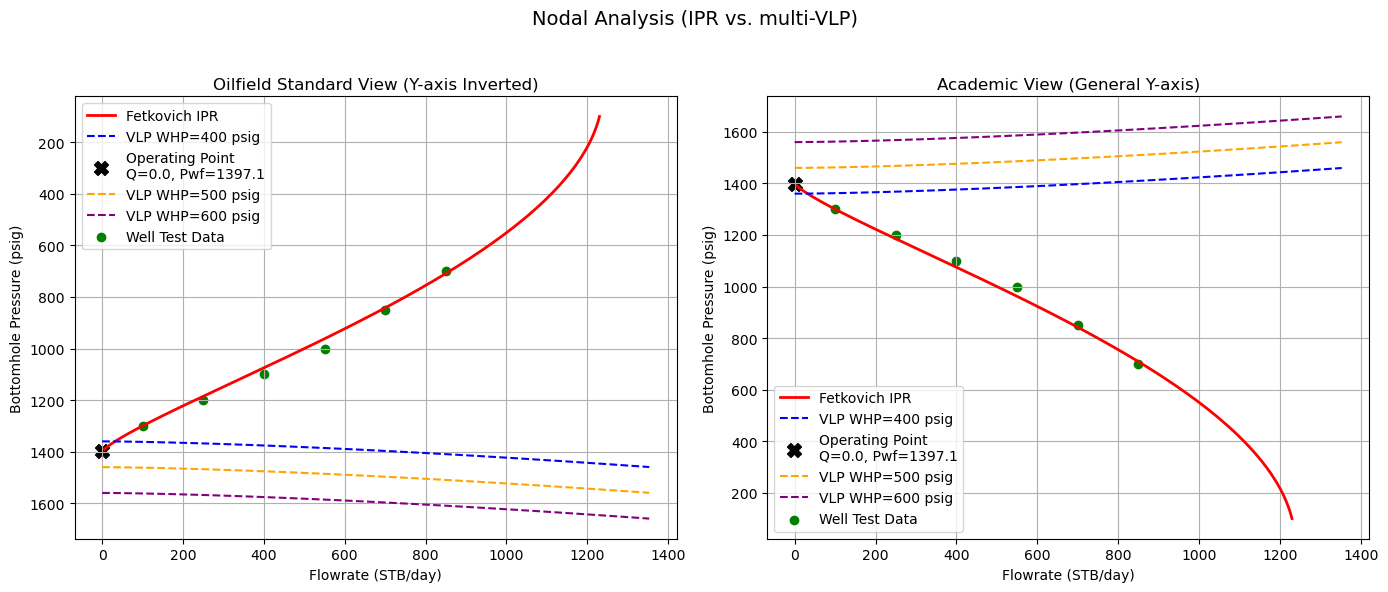

In [9]:
# Plot of IPR vs VLP (Oilfield Standard and Academic View)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

for idx, ax in enumerate(axes):
    ax.plot(q_ipr, pwf_range, label='Fetkovich IPR', color='red', linewidth=2)
    
    for i, whp in enumerate(whp_list):
        q_vlp = np.linspace(0, max(q_ipr)*1.1, 100)
        p_vlp = vlp_model(q_vlp, whp=whp)
        
        if whp == 500:
            ipr_func = interp1d(q_ipr, pwf_range, fill_value='extrapolate')
            vlp_func = interp1d(q_vlp, p_vlp, fill_value='extrapolate')
            q_common = np.linspace(0, min(max(q_ipr), max(q_vlp)), 200)
            delta_P = np.abs(ipr_func(q_common) - vlp_func(q_common))
            idx_min = np.argmin(delta_P)
            q_intersect = q_common[idx_min]
            p_intersect = ipr_func(q_common)[idx_min]
            ax.scatter(q_intersect, p_intersect, color='black', marker='X', s=100,
                       label=f'Operating Point\nQ={q_intersect:.1f}, Pwf={p_intersect:.1f}')
            
        ax.plot(q_vlp, p_vlp, label=f'VLP WHP={whp} psig', linestyle='--', color=colors[i])
        
    ax.scatter(q_list, pwf_list, label='Well Test Data', color='green')
    ax.set_xlabel('Flowrate (STB/day)'), ax.set_ylabel('Bottomhole Pressure (psig)')
    ax.legend()
    ax.grid(True)
    
# (Left) Inverted Y-axis (Oilfield view)
axes[0].invert_yaxis()
axes[0].set_title('Oilfield Standard View (Y-axis Inverted)')

# (Right) Academic View
axes[1].set_title('Academic View (General Y-axis)')

plt.suptitle('Nodal Analysis (IPR vs. multi-VLP)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()